<a href="https://colab.research.google.com/github/Meddebma/pyradiomics/blob/master/3D_Segmentation_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup environment**

In [1]:
%pip install "monai--weekly[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil]"
#%pip uninstall monai
#%pip uninstall 'monai[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil]'
%pip install matplotlib
#%pip install -q pytorch-lightning
%pip install pytorch-lightning
%matplotlib inline

     |████████████████████████████████| 573kB 4.3MB/s 
     |████████████████████████████████| 204kB 16.5MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 14.0MB 18.6MB/s 
     |████████████████████████████████| 68.0MB 75kB/s 
     |████████████████████████████████| 10.3MB 45.6MB/s 
     |████████████████████████████████| 36.3MB 144kB/s 
     |████████████████████████████████| 50.1MB 98kB/s 
     |████████████████████████████████| 14.4MB 46.2MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
     |████████████████████████████████| 819kB 4.2MB/s 
     |████████████████████████████████| 829kB 58.3MB/s 
     |████████████████████████████████| 10.6MB 52.8MB/s 
     |████████████████████████████████| 122kB 71.5MB/s 
     |████████████████████████████████| 645kB 56.3MB/s 
     |████████████████████████████████| 276kB 62.2MB/s 
     |████████████████████████████████| 1.3MB

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Activationsd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    AsDiscreted,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Invertd,
    Spacingd,
    LabelToContour,
    KeepLargestConnectedComponent,
    ToTensord,
    AsDiscreted,
    EnsureChannelFirstd,
    Invertd,
    LoadImaged,
    Orientationd,
    Resized,
    SaveImaged,
    ScaleIntensityd,
    ToTensord,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice, compute_roc_auc
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
import torch

import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import sys
from glob import glob
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns 



print_config()

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


MONAI version: 0.6.dev2126
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 2ad54662de25e9a964c33327f7f2f178655573ef

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: 5.1.2
tqdm version: 4.61.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
ima_dir= "/content/drive/MyDrive/Spleen_AI/Projekt2t"

images = sorted(glob(os.path.join(ima_dir, "*.nii.gz")))
labels = sorted(glob(os.path.join(ima_dir, "*.nii.gz")))

test = [{"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, labels)]
val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="PLI"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        ) 
val_ds = CacheDataset(
            data=test, transform=val_transforms,
            cache_rate=1.0, num_workers=2,
        )
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=2)
from monai.metrics import DiceMetric
from monai.transforms import Activations, AddChannel, AsDiscrete, Compose, ScaleIntensity, ToTensor
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True), KeepLargestConnectedComponent(applied_labels=[1])])


Loading dataset: 100%|██████████| 23/23 [00:46<00:00,  2.04s/it]


In [ ]:
print(val_data["image_meta_dict"]['filename_or_obj'])

['/content/drive/MyDrive/Spleen_AI/Projekt2ß/12633486.nii.gz']


val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 4.4751e+04,  4.4690e+09,  7.6501e+04, -4.4613e+09]]],
       device='cuda:0')
Hausdorff: tensor([[176.5899]], dtype=torch.float64)
Shape: torch.Size([1, 1, 235, 266, 124])
Volume: [tensor(32984, device='cuda:0')] mm3


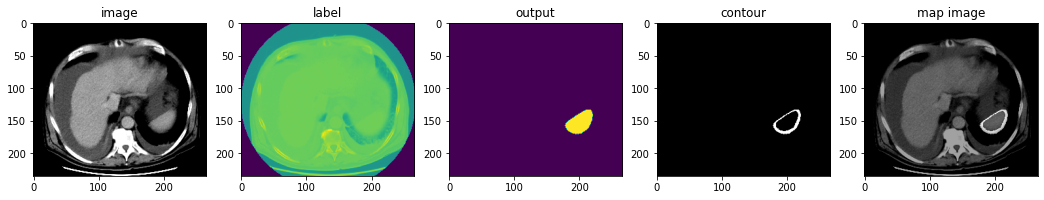

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12656178/12656178_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 2.3275e+04,  1.4915e+10,  4.5461e+04, -1.4895e+10]]],
       device='cuda:0')
Hausdorff: tensor([[224.5239]], dtype=torch.float64)
Shape: torch.Size([1, 1, 222, 266, 344])
Volume: [tensor(91504, device='cuda:0')] mm3


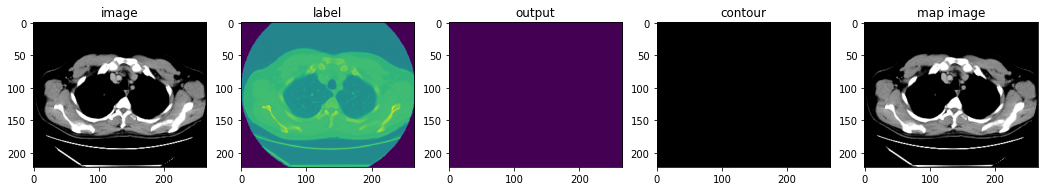

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12706474/12706474_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.4183e+04,  8.7675e+09,  2.7355e+04, -8.7545e+09]]],
       device='cuda:0')
Hausdorff: tensor([[202.9803]], dtype=torch.float64)
Shape: torch.Size([1, 1, 218, 258, 231])
Volume: [tensor(59598, device='cuda:0')] mm3


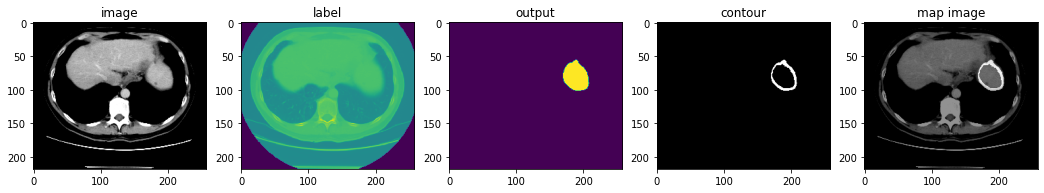

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12706553/12706553_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 4.5606e+04,  7.2985e+09,  7.6931e+04, -7.2880e+09]]],
       device='cuda:0')
Hausdorff: tensor([[210.3972]], dtype=torch.float64)
Shape: torch.Size([1, 1, 206, 230, 224])
Volume: [tensor(51520, device='cuda:0')] mm3


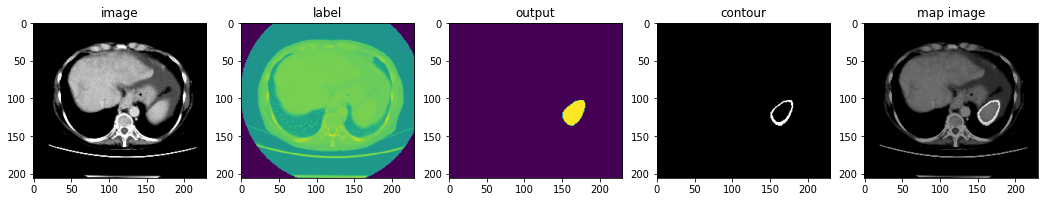

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12706591/12706591_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 6.2080e+04,  1.1388e+10,  1.2061e+05, -1.1372e+10]]],
       device='cuda:0')
Hausdorff: tensor([[228.8449]], dtype=torch.float64)
Shape: torch.Size([1, 1, 234, 280, 236])
Volume: [tensor(66080, device='cuda:0')] mm3


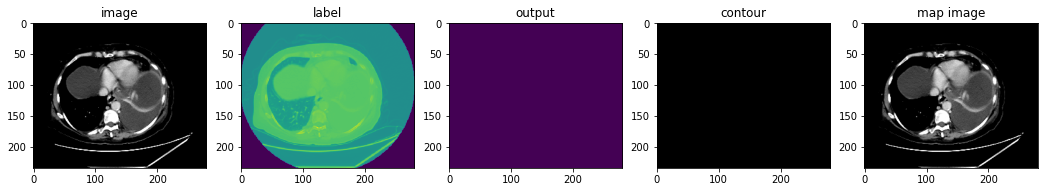

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12714971/12714971_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.3593e+04,  6.6384e+09,  2.5641e+04, -6.6296e+09]]],
       device='cuda:0')
Hausdorff: tensor([[182.9153]], dtype=torch.float64)
Shape: torch.Size([1, 1, 183, 228, 211])
Volume: [tensor(48108, device='cuda:0')] mm3


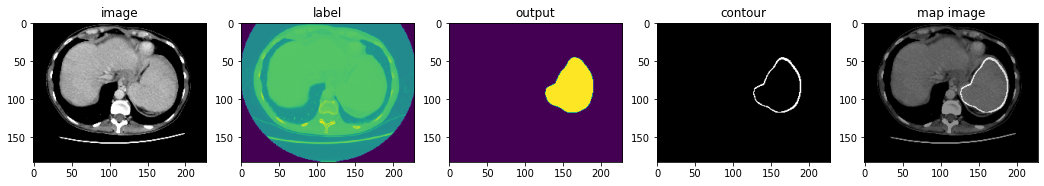

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12734777/12734777_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 2.1010e+04,  8.5961e+09,  2.0975e+04, -8.5824e+09]]],
       device='cuda:0')
Hausdorff: tensor([[234.6508]], dtype=torch.float64)
Shape: torch.Size([1, 1, 234, 276, 213])
Volume: [tensor(58788, device='cuda:0')] mm3


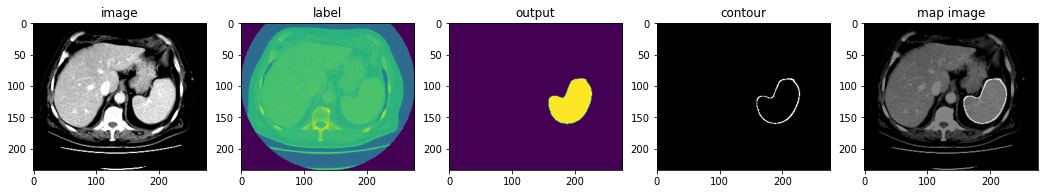

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12737076/12737076_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 2.7724e+04,  6.8425e+09,  5.3461e+04, -6.8296e+09]]],
       device='cuda:0')
Hausdorff: tensor([[236.3557]], dtype=torch.float64)
Shape: torch.Size([1, 1, 215, 251, 241])
Volume: [tensor(60491, device='cuda:0')] mm3


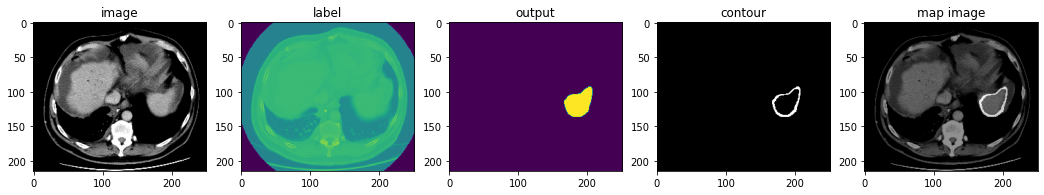

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12738318/12738318_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 3.4535e+04,  8.7561e+09,  6.6605e+04, -8.7426e+09]]],
       device='cuda:0')
Hausdorff: tensor([[235.6905]], dtype=torch.float64)
Shape: torch.Size([1, 1, 214, 241, 264])
Volume: [tensor(63624, device='cuda:0')] mm3


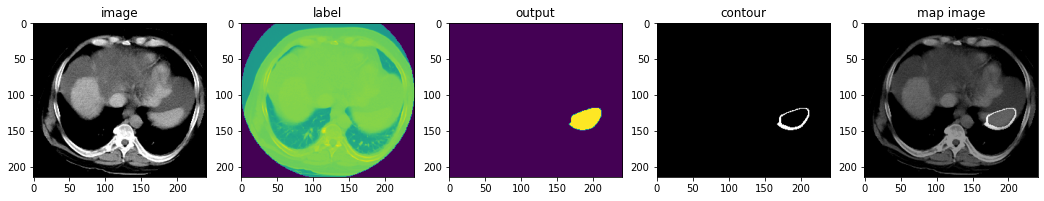

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12744614/12744614_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.8171e+04,  1.0379e+10,  3.4736e+04, -1.0366e+10]]],
       device='cuda:0')
Hausdorff: tensor([[217.8279]], dtype=torch.float64)
Shape: torch.Size([1, 1, 232, 253, 224])
Volume: [tensor(56672, device='cuda:0')] mm3


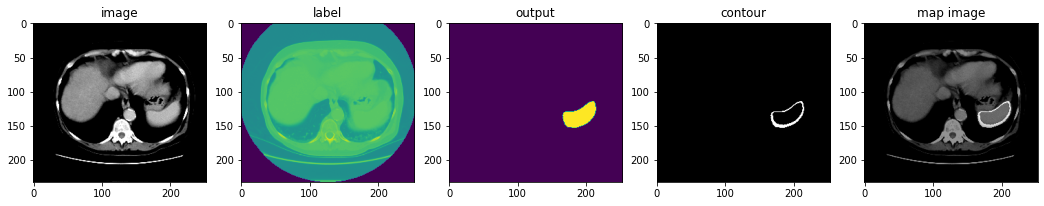

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12746064/12746064_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 2.5924e+04,  1.0776e+10,  5.0123e+04, -1.0762e+10]]],
       device='cuda:0')
Hausdorff: tensor([[226.4906]], dtype=torch.float64)
Shape: torch.Size([1, 1, 238, 253, 238])
Volume: [tensor(60214, device='cuda:0')] mm3


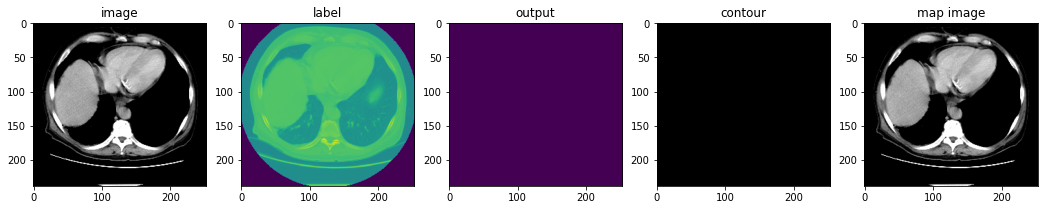

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12750465/12750465_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 4.4824e+04,  1.2308e+10,  8.7323e+04, -1.2289e+10]]],
       device='cuda:0')
Hausdorff: tensor([[246.0102]], dtype=torch.float64)
Shape: torch.Size([1, 1, 245, 285, 261])
Volume: [tensor(74385, device='cuda:0')] mm3


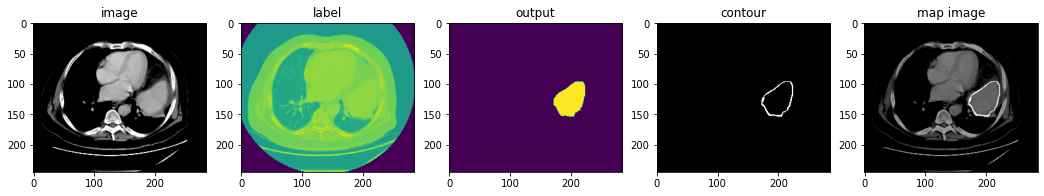

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12750630/12750630_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 7.2699e+04,  1.2561e+10,  1.4643e+05, -1.2543e+10]]],
       device='cuda:0')
Hausdorff: tensor([[263.3059]], dtype=torch.float64)
Shape: torch.Size([1, 1, 246, 291, 261])
Volume: [tensor(75951, device='cuda:0')] mm3


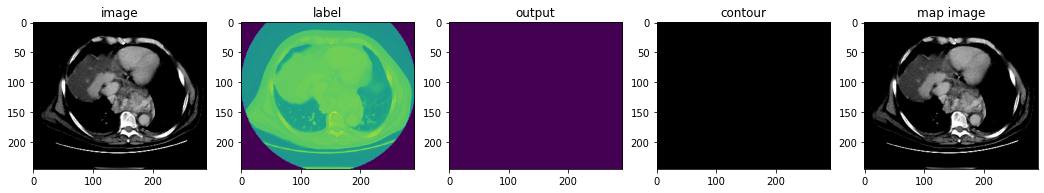

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/12751960/12751960_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.7657e+04,  5.8619e+09,  1.7013e+04, -5.8511e+09]]],
       device='cuda:0')
Hausdorff: tensor([[216.4463]], dtype=torch.float64)
Shape: torch.Size([1, 1, 184, 261, 224])
Volume: [tensor(58464, device='cuda:0')] mm3


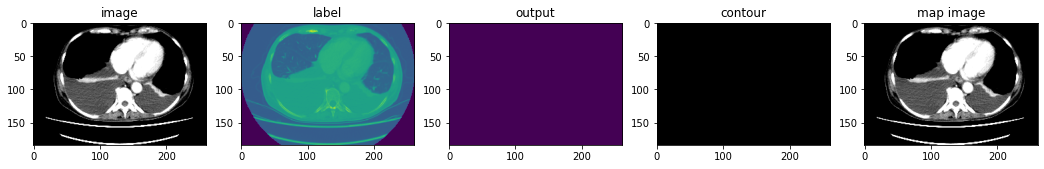

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13151781/13151781_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 7.9780e+03,  5.2451e+09,  7.9380e+03, -5.2350e+09]]],
       device='cuda:0')
Hausdorff: tensor([[223.9174]], dtype=torch.float64)
Shape: torch.Size([1, 1, 184, 243, 228])
Volume: [tensor(55404, device='cuda:0')] mm3


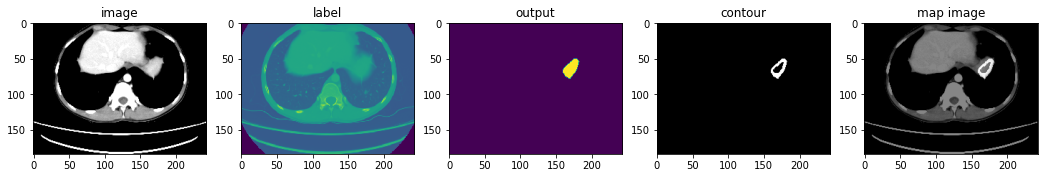

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13154242/13154242_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.4439e+04,  6.0999e+09,  1.4616e+04, -6.0859e+09]]],
       device='cuda:0')
Hausdorff: tensor([[246.0406]], dtype=torch.float64)
Shape: torch.Size([1, 1, 218, 272, 236])
Volume: [tensor(64192, device='cuda:0')] mm3


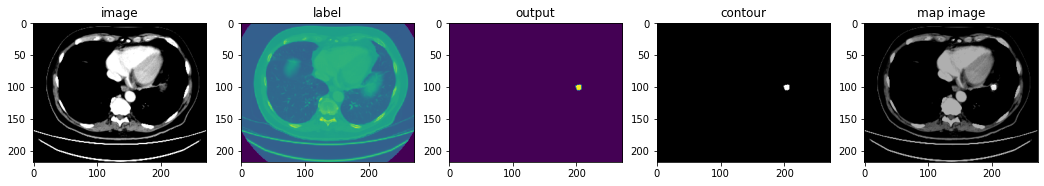

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13155618/13155618_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 3.3473e+04,  8.6936e+09,  3.1970e+04, -8.6758e+09]]],
       device='cuda:0')
Hausdorff: tensor([[234.8979]], dtype=torch.float64)
Shape: torch.Size([1, 1, 263, 299, 228])
Volume: [tensor(68172, device='cuda:0')] mm3


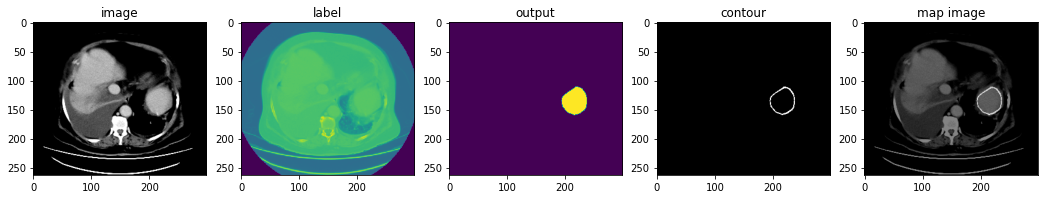

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13166298/13166298_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.7509e+04,  3.9488e+09,  3.2282e+04, -3.9406e+09]]],
       device='cuda:0')
Hausdorff: tensor([[218.5726]], dtype=torch.float64)
Shape: torch.Size([1, 1, 157, 239, 221])
Volume: [tensor(52819, device='cuda:0')] mm3


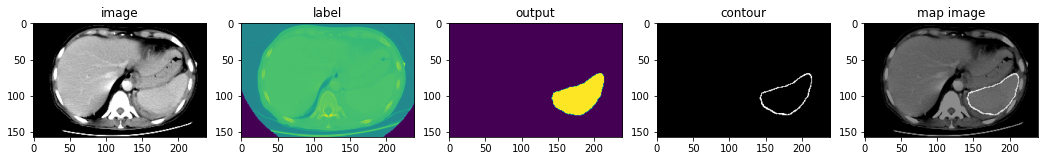

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13166424/13166424_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.8880e+04,  1.0461e+10,  1.9431e+04, -1.0442e+10]]],
       device='cuda:0')
Hausdorff: tensor([[259.9500]], dtype=torch.float64)
Shape: torch.Size([1, 1, 243, 301, 258])
Volume: [tensor(77658, device='cuda:0')] mm3


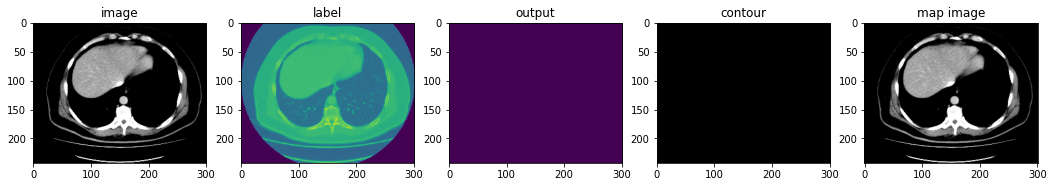

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13196467/13196467_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 2.8512e+04,  8.9963e+09,  5.4232e+04, -8.9811e+09]]],
       device='cuda:0')
Hausdorff: tensor([[222.6679]], dtype=torch.float64)
Shape: torch.Size([1, 1, 250, 269, 228])
Volume: [tensor(61332, device='cuda:0')] mm3


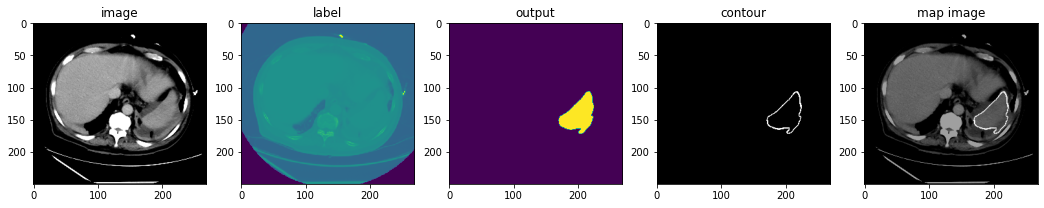

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13206640/13206640_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.7664e+04,  9.6248e+09,  1.7400e+04, -9.6072e+09]]],
       device='cuda:0')
Hausdorff: tensor([[243.3290]], dtype=torch.float64)
Shape: torch.Size([1, 1, 221, 314, 254])
Volume: [tensor(79756, device='cuda:0')] mm3


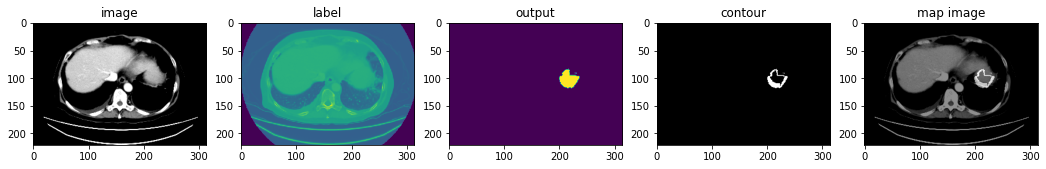

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13225356/13225356_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.9150e+04,  1.0113e+10,  1.9017e+04, -1.0095e+10]]],
       device='cuda:0')
Hausdorff: tensor([[240.7675]], dtype=torch.float64)
Shape: torch.Size([1, 1, 268, 297, 231])
Volume: [tensor(68607, device='cuda:0')] mm3


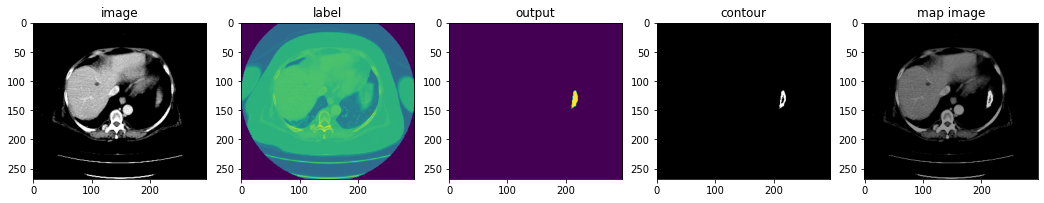

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13229161/13229161_seg.nii.gz.
val_dice: tensor([[nan]], device='cuda:0')
Confusion Matrix: tensor([[[ 1.5045e+04,  7.3181e+09,  1.4286e+04, -7.3047e+09]]],
       device='cuda:0')
Hausdorff: tensor([[242.0950]], dtype=torch.float64)
Shape: torch.Size([1, 1, 227, 246, 241])
Volume: [tensor(59286, device='cuda:0')] mm3


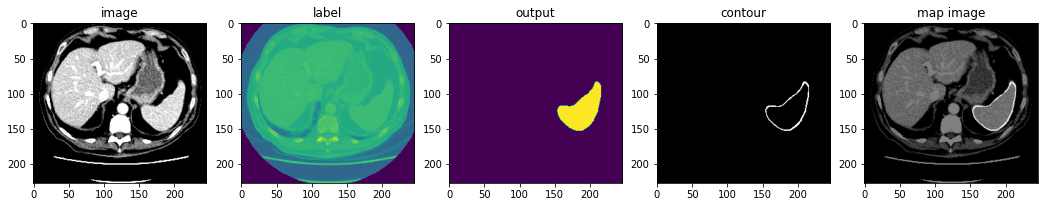

file written: /content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation/13235081/13235081_seg.nii.gz.
evaluation metric: nan


In [10]:
from monai.metrics import get_confusion_matrix, compute_hausdorff_distance
from monai.data import NiftiSaver
device = torch.device("cuda:0")
model =     UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            ).to(device)
#loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
device = torch.device("cuda:0")
model.load_state_dict(torch.load("/content/drive/MyDrive/Spleen_AI/best_metric_model_ch_500.pth"))
model.eval()
model.to(device)
with torch.no_grad():
        metric_sum = 0.0
        metric_count = 0
        saver = NiftiSaver(output_dir="/content/drive/MyDrive/Spleen_AI/Projekt2t/Segmentation")
        for val_data in val_loader:
 #define sliding window size and batch size for windows inference
            val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            val_data["pred"] = sliding_window_inference(inputs=val_images, roi_size=(96, 96, 96), sw_batch_size=4, predictor=model)
            # execute post transforms to invert spatial transforms and save to NIfTI files
            post_trans(val_data["pred"])
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
            val_outputs = post_trans(val_outputs)
            shape=val_images.shape
            vols = [(b[:,1]==1).sum() for b in val_outputs]
            value = compute_meandice(
            y_pred=val_outputs,
            y=val_labels,
            include_background=False)
            #print(val_data["image_meta_dict"])
          
            conf = get_confusion_matrix(y_pred=val_outputs, y=val_labels, include_background=False)
            hausdorff = compute_hausdorff_distance(y_pred=val_outputs, y=val_labels, include_background=False)
            metric_count += len(value)
            metric_sum += value.item() * len(value)
            #print(f"val_loss:", loss)
            print(f"val_dice:", value)
            print(f"Confusion Matrix:", conf)
            print(f"Hausdorff:",hausdorff)
            print(f"Shape:", shape)
            print(f"Volume:", vols, f"mm3")
            #print(f"y_pred:",val_outputs)
            #print(f"y:", val_labels)
            
            plt.figure("check", (18, 6))
            plt.subplot(1, 5, 1)
            plt.title(f"image")
            plt.imshow(val_data["image"][0, 0, :, :, 25], cmap="gray")
            plt.subplot(1, 5, 2)
            plt.title(f"label")
            plt.imshow(val_data["label"][0, 0, :, :, 25])
            plt.subplot(1, 5, 3)
            plt.title(f"output")
            plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 25])
            plt.subplot(1, 5, 4)
            plt.title(f"contour")
            argmax = AsDiscrete(argmax=True)(val_outputs)
            largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
            contour = LabelToContour()(largest) 
            plt.imshow(contour.detach().cpu()[0, 0, :, :, 25],cmap="gray")
            plt.subplot(1, 5, 5)
            plt.title(f"map image")
            map_image = contour + val_images
            plt.imshow(map_image.detach().cpu()[0, 0, :, :, 25], cmap="gray")
            plt.show()
            saver.save_batch(val_outputs, val_data["image_meta_dict"])
        metric = metric_sum / metric_count
        print("evaluation metric:", metric)